# Homework 8
### Gabriel Taylor and Jacob Smith

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [2]:
randstate = 1000

In [3]:
df = pd.read_csv('lendingclub.csv')

In [4]:
df.head()

home_ownership  income    dti  fico  loan_status
0               1    43.0  39.66   670            0
1               1    80.0  39.54   685            1
2               0    30.0  39.52   695            1
3               1   105.0  39.45   710            0
4               0    28.6  39.28   680            1

# **Exploratory Data Analysis (EDA)**

In [5]:
# let's look at how many unique observations we have

df.nunique()

home_ownership       2
income             470
dti               1617
fico                34
loan_status          2
dtype: int64

In [6]:
df.sample(10)

home_ownership  income    dti  fico  loan_status
245                0    48.0  30.13   675            0
979                1    52.0  20.33   670            1
1084               1    82.0  18.91   690            0
1601               0   134.0  13.68   665            1
751                1    65.0  22.92   705            0
2191               0   150.0   4.33   690            1
608                0    55.0  24.63   670            1
1491               1    58.6  14.82   675            1
2080               1    90.0   6.89   660            1
464                0    32.0  26.67   700            1

In [7]:
# no NA values, this is great!

pd.isnull(df).sum()

home_ownership    0
income            0
dti               0
fico              0
loan_status       0
dtype: int64

In [8]:
# no duplicate values, this is great!

sum(df.duplicated())

0

In [9]:
df.describe(include='all').T

count        mean        std     min       25%     50%  \
home_ownership  2270.0    0.573568   0.494667    0.00    0.0000    1.00   
income          2270.0   74.058571  39.335066   20.00   46.0000   65.00   
dti             2270.0   18.907824   8.460242    0.74   12.6175   18.42   
fico            2270.0  692.504405  28.854947  660.00  670.0000  685.00   
loan_status     2270.0    0.649339   0.477282    0.00    0.0000    1.00   

                     75%     max  
home_ownership    1.0000    1.00  
income           92.0000  250.00  
dti              25.2875   39.66  
fico            705.0000  845.00  
loan_status       1.0000    1.00

- With the above table we see that the average *FICO* score is ~700; very good.
- I'm intrigued to see the relationship between *FICO* scores and *loan_status*.

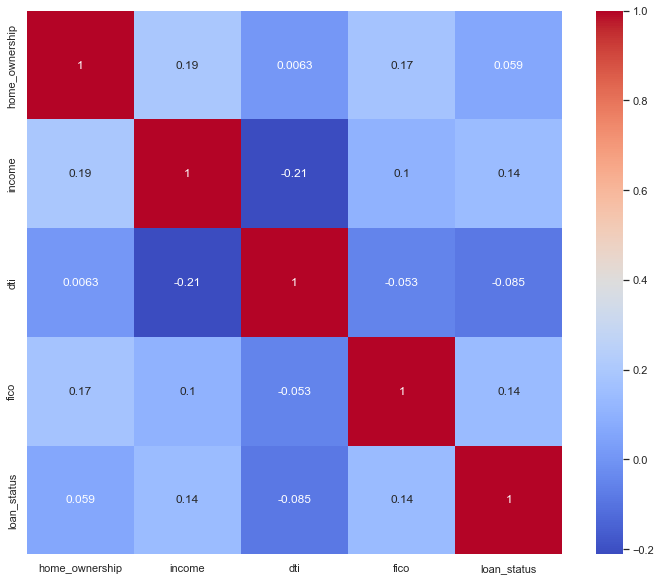

In [10]:
# let's first look at the correlations between our variables

plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True)
plt.show()

- Surprisingly not a huge correlation between *FICO* scores and *home_ownership* although the relationship is positive (0.17). 
- It makes sense that *dti* and *loan_status* are negatively correlated as more current debt makes banks unwilling to lend more to you. 

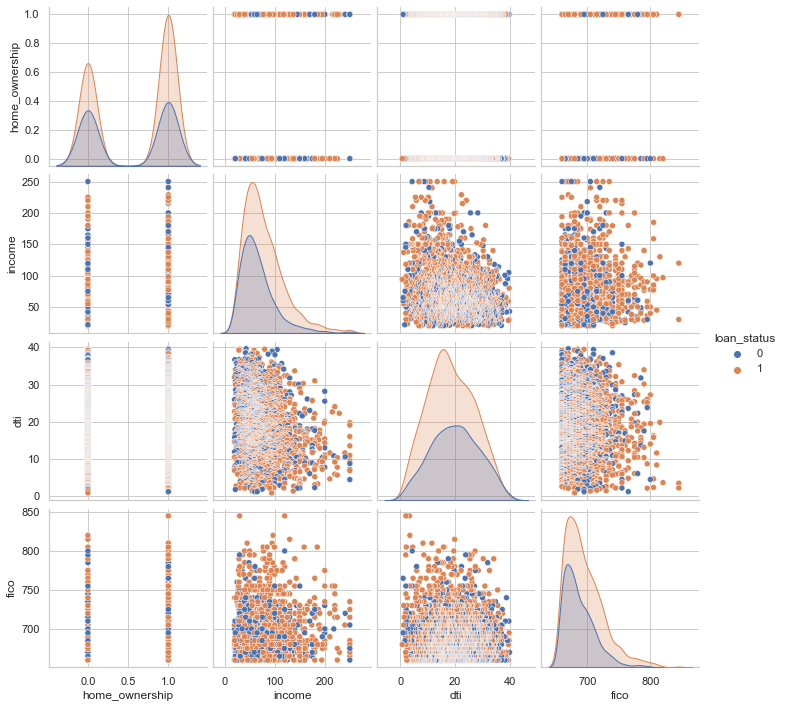

In [11]:
# let's take a look at our pairplot

sns.set_style('whitegrid')
sns.pairplot(df, hue = 'loan_status')
plt.show()

- These figures are interesting as they may help explain some difficulty later on. 
- Seeing as the relationship between variables have no clear split. 
- I would have hypothesized that *FICO* scores and *income* would have showed a more distinct split along with *dti* and *FICO* (i.e., a higher credit score implies a lower current *dti*). 

<AxesSubplot:xlabel='fico'>

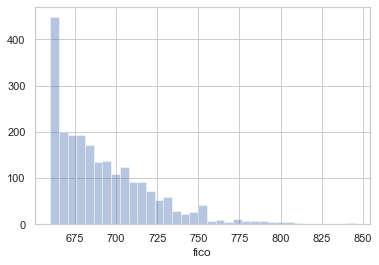

In [12]:
# what is the distribution of FICO scores?

sns.distplot(df['fico'], norm_hist=False, kde=False)

In [13]:
np.min(df['fico'])

660

- Seems that most of our data is coming from individuals with FICO scores of ~660. 

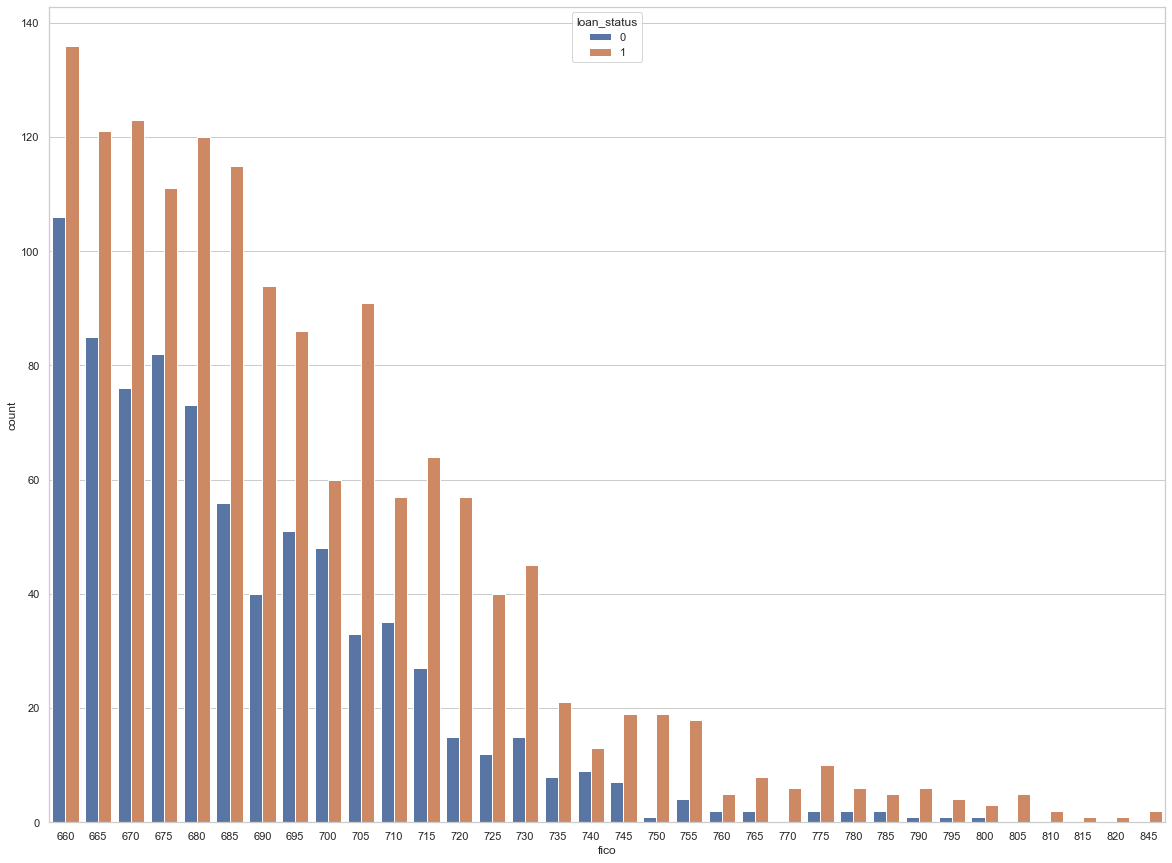

In [14]:
# let's take a look at the relationship between loan status and fico score

plt.figure(figsize = (20, 15))
FICO = sns.countplot(x = 'fico', hue = 'loan_status', data = df)
plt.show()

- With a relatively balanced data set, we can conclude that those who have a higher fico score are more probable to have a loan that is in good condition. As we decrease fico score, the probability of finding someone who has defaulted on a loan increases dramatically. 

---

# **Decision Tree Classification**

## Question 1

In [15]:
pd.crosstab(df['loan_status'], df['loan_status'], normalize='all')*100

loan_status          0          1
loan_status                      
0            35.066079   0.000000
1             0.000000  64.933921

- Data set is relatively balanced. Roughly 65% are good condition loans while 35% are defaults.

---

## Question 2

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
y = df['loan_status']
X = df.drop('loan_status', axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=randstate)

---

## Question 3

#### Part 1


In [18]:
from sklearn.tree import DecisionTreeClassifier

In [19]:
Tree_classifier = DecisionTreeClassifier()
Tree_classifier.fit(X_train, y_train)

DecisionTreeClassifier()

#### Part 2

In [20]:
y_hat = Tree_classifier.predict(X_test)

#### Part 3

In [21]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

##### Confusion Matrix

In [22]:
print(confusion_matrix(y_test, y_hat))

[[ 62  98]
 [113 181]]


- Tons of false negatives here. Curious if we can significantly reduce this number through optimization (pruning). 

##### Classification Report

In [23]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.35      0.39      0.37       160
           1       0.65      0.62      0.63       294

    accuracy                           0.54       454
   macro avg       0.50      0.50      0.50       454
weighted avg       0.54      0.54      0.54       454



In terms of predicting bad condition loans:

1. Accuracy -- 55%
2. Precison -- 37%
3. Recall -- 40% 
4. F1 -- 39% 

- These numbers seem normal in terms of a vanilla, non-optimized model. The data set is pretty well balanced (65% good to 35% bad) so we can trust the accuracy figure of 55%.  

---

## Question 4

In [43]:
path = DecisionTreeClassifier().cost_complexity_pruning_path(X_train, y_train)
print(path)

{'ccp_alphas': array([0.        , 0.00029369, 0.0003304 , 0.00033373, 0.00034263,
       0.00034263, 0.00034263, 0.00035042, 0.00035745, 0.00036711,
       0.00036711, 0.00036711, 0.00036711, 0.00036711, 0.00036711,
       0.00037275, 0.000413  , 0.000413  , 0.000413  , 0.000413  ,
       0.000413  , 0.000413  , 0.000413  , 0.000413  , 0.000413  ,
       0.000413  , 0.00044053, 0.00044053, 0.00044053, 0.00044053,
       0.00044053, 0.00044053, 0.00044053, 0.00044053, 0.00044053,
       0.00044053, 0.00044201, 0.00045054, 0.00045888, 0.00045888,
       0.00045888, 0.00045888, 0.00045888, 0.00045888, 0.00045888,
       0.00045888, 0.00045888, 0.00047199, 0.00047199, 0.00047199,
       0.00047199, 0.00048183, 0.00048183, 0.00048183, 0.00048948,
       0.00048948, 0.00048948, 0.00048948, 0.00048948, 0.00049504,
       0.00049559, 0.00049559, 0.00049559, 0.00049559, 0.00049559,
       0.00049559, 0.00050477, 0.0005083 , 0.0005083 , 0.00050932,
       0.00051395, 0.00051395, 0.00051624, 0.00

In [25]:
ccp_alphas = path.ccp_alphas

In [26]:
from sklearn.model_selection import cross_val_score
import sklearn.metrics

In [27]:
# borrowing Pedram's code

accuracy_cv =[]
for alpha in ccp_alphas:
    accuracy = cross_val_score(estimator = DecisionTreeClassifier(ccp_alpha=alpha), X = X_train, y = y_train, cv = 5 , scoring="accuracy" )
    accuracy_cv.append(np.mean(accuracy))
    
output = pd.DataFrame(list(ccp_alphas), columns=['alpha'])
output['accuracy_CV']=accuracy_cv

output.head()

alpha  accuracy_CV
0  0.000000     0.551766
1  0.000294     0.553967
2  0.000330     0.548461
3  0.000337     0.553964
4  0.000343     0.547907

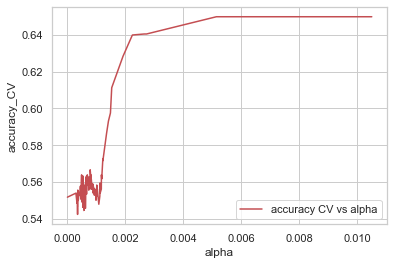

In [28]:
sns.lineplot(x='alpha', y='accuracy_CV', data=output, color='r', label='accuracy CV vs alpha')
plt.show()

In [29]:
output.iloc[np.argmax(output['accuracy_CV']),]

alpha          0.005143
accuracy_CV    0.649781
Name: 212, dtype: float64

- Maximum accuracy is ~65% with an $Î±$ level of 0.005. 

---

## Question 5

In [30]:
optimal_alpha = output.iloc[np.argmax(output['accuracy_CV']),0]
optimal_alpha

0.005142538659615947

In [31]:
optimal_DT = DecisionTreeClassifier(ccp_alpha=optimal_alpha)
optimal_DT.fit(X_train, y_train)
y_hat_optimized = optimal_DT.predict(X_test)

---

## Question 6

##### Confusion Matrix

In [32]:
print(confusion_matrix(y_test, y_hat_optimized))

[[  0 160]
 [  0 294]]


##### Classification Report

In [33]:
print(classification_report(y_test, y_hat_optimized))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       160
           1       0.65      1.00      0.79       294

    accuracy                           0.65       454
   macro avg       0.32      0.50      0.39       454
weighted avg       0.42      0.65      0.51       454



In terms of predicting good condition loans:

1. Accuracy -- 65%
2. Precison -- 65%
3. Recall -- 100% 
4. F1 -- 79%

- The numbers when predicting default loans are awfully weird though. For example, our "optimal model" has a precision, recall, and f1-score of $0$ when predicting default loans. This is alarming. 

---

## Question 7

In [34]:
from sklearn.model_selection import cross_val_score

In [35]:
optimized_accuracy_test = cross_val_score(estimator = optimal_DT, X=X_train, y=y_train, cv=5, scoring='accuracy')
optimized_accuracy_test

array([0.64835165, 0.65013774, 0.65013774, 0.65013774, 0.65013774])

In [36]:
round(optimized_accuracy_test.mean(), 3)

0.65

---

## Question 8

In [37]:
dtree = DecisionTreeClassifier(max_depth=4, min_samples_leaf=50)
dtree.fit(X_train, y_train)
yhat = dtree.predict(X_test)

In [38]:
from sklearn.tree import plot_tree

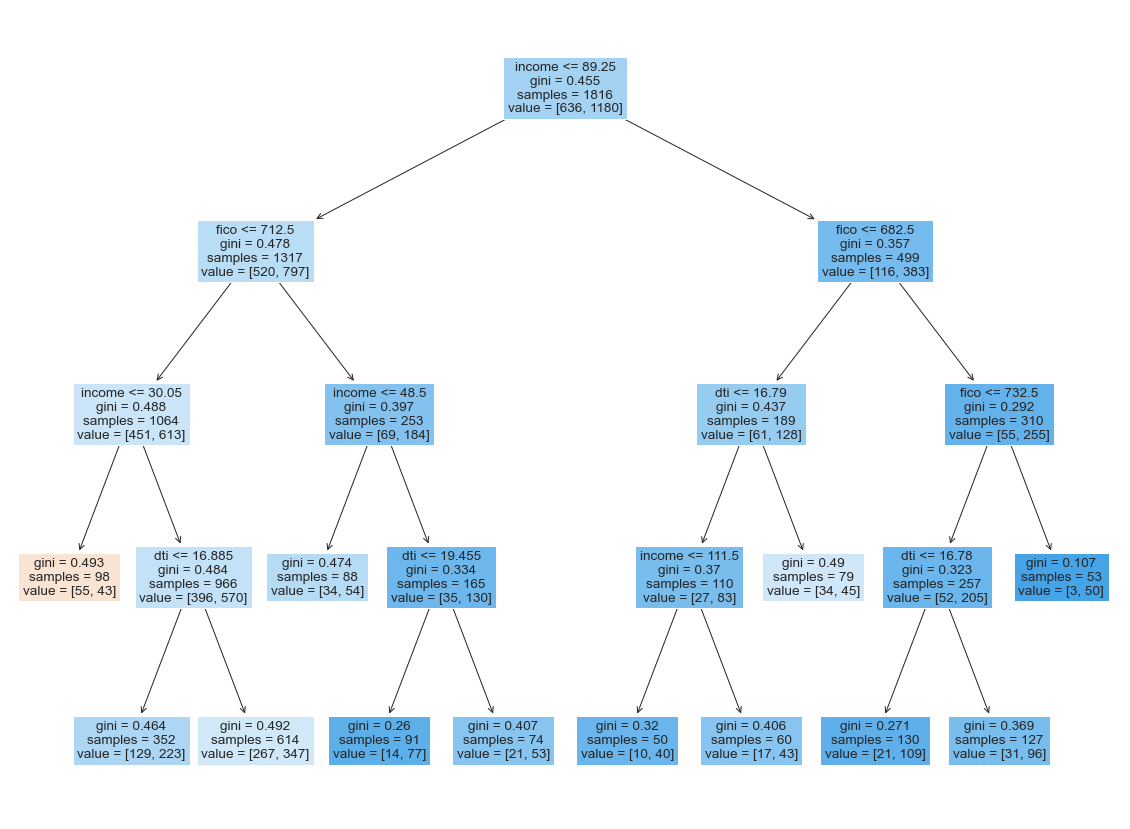

In [39]:
fig = plt.figure(figsize=(20,15))
DT_plot = plot_tree(dtree, feature_names=X_train.columns, filled=True)

#### Part 1

- The best feature to start with appears to be income, where the cutoff point is any value of income less than or equal to 89.25.



#### Part 2

- If $income \leq 89.25$, then we proceed to the left and look at FICO score. If $FICO \leq 712.5$, proceed to the left and check income again. If $income \leq 30.05$, then predict default. 

#### Part 3

- In this decision tree, we count 12 terminal nodes. This number is less than 16 as we imposed a limit as to how many observations must be in each node. In our case, we must see at least 50 observations in each node. This is because of our code: "min_samples_leaf=50"
- If we were to remove this limit, the DT would continue splitting and we would likely see more terminal nodes albeit less observations in each node.

#### Part 4

- Partially, yes. I think for the most part our terminal nodes are relatively pure although I am concerned regarding the nodes that have gini impurity values $\gt 0.4$. We know that gini impurity values range from $0-0.5$ with $0$ being a perfectly pure node. With the nodes that have such high gini impurity values, the probability of misclassification is high which is alarming. 

---
---